In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

To forecast the sales of the two best-selling products, I will split the dataset into two, one for item A and one for item B.

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Keep only one observation per day
data = data.drop_duplicates(subset=['date', 'item_name'], keep='first')

# Filter the data for item_name 'A'
data_a = data[data['item_name'] == 'A']

# Filter the data for item_name 'B'
data_b = data[data['item_name'] == 'B']

# Save the filtered data to new CSV files
data_a.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index=False)
data_b.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index=False)

Features processing A and B

In [ ]:
# Model SVR A

data_a = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index_col='date')

# Convert the index to datetime format
data_a.index = pd.to_datetime(data_a.index)

# Check the number of unique values in 'item_nbr', 'item_name', and 'class'
print("Unique values in 'item_nbr':", data_a['item_nbr'].nunique())
print("Unique values in 'item_name':", data_a['item_name'].nunique())
print("Unique values in 'class':", data_a['class'].nunique())

# If these columns have only one unique value, drop them from the dataset
if data_a['item_nbr'].nunique() == 1:
    data_a.drop('item_nbr', axis=1, inplace=True)
if data_a['item_name'].nunique() == 1:
    data_a.drop('item_name', axis=1, inplace=True)
if data_a['class'].nunique() == 1:
    data_a.drop('class', axis=1, inplace=True)

# Also, drop the 'id' column as it is just an identifier
data_a.drop('id', axis=1, inplace=True)

#data_a.drop(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'], axis=1, inplace=True)
#data_a.drop(['month_sin', 'day_of_month_sin', 'week_of_month_sin', 'day_of_week_sin', 'season_sin', 'month_cos', 'day_of_month_cos', 'week_of_month_cos', 'day_of_week_cos', 'season_cos'], axis=1, inplace=True)
print(data_a.head())

Unique values in 'item_nbr': 1
Unique values in 'item_name': 1
Unique values in 'class': 1
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-01-02         117        False           False              True   
2015-01-03         110        False           False             False   
2015-01-04         180        False           False             False   
2015-01-05         106        False           False             False   
2015-01-06          87        False           False             False   

            holiday_local  month  day_of_month  week_of_month  day_of_week  \
date                                                                         
2015-01-02          False      1             2              1            5   
2015-01-03          False      1             3              1            6   
2015-01-04          False      1             4              1            7   
2015-01

In [ ]:
# Model SVR A

data_b = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index_col='date')

# Convert the index to datetime format
data_b.index = pd.to_datetime(data_b.index)

# Check the number of unique values in 'item_nbr', 'item_name', and 'class'
print("Unique values in 'item_nbr':", data_b['item_nbr'].nunique())
print("Unique values in 'item_name':", data_b['item_name'].nunique())
print("Unique values in 'class':", data_b['class'].nunique())

# If these columns have only one unique value, drop them from the dataset
if data_b['item_nbr'].nunique() == 1:
    data_b.drop('item_nbr', axis=1, inplace=True)
if data_b['item_name'].nunique() == 1:
    data_b.drop('item_name', axis=1, inplace=True)
if data_b['class'].nunique() == 1:
    data_b.drop('class', axis=1, inplace=True)

# Also, drop the 'id' column as it is just an identifier
data_b.drop('id', axis=1, inplace=True)

#data_b.drop(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'], axis=1, inplace=True)
#data_b.drop(['month_sin', 'day_of_month_sin', 'week_of_month_sin', 'day_of_week_sin', 'season_sin', 'month_cos', 'day_of_month_cos', 'week_of_month_cos', 'day_of_week_cos', 'season_cos'], axis=1, inplace=True)
print(data_b.head())

Unique values in 'item_nbr': 1
Unique values in 'item_name': 1
Unique values in 'class': 1
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-01-02          90        False           False              True   
2015-01-03          97        False           False             False   
2015-01-04          94        False           False             False   
2015-01-05          81        False           False             False   
2015-01-06         119        False           False             False   

            holiday_local  month  day_of_month  week_of_month  day_of_week  \
date                                                                         
2015-01-02          False      1             2              1            5   
2015-01-03          False      1             3              1            6   
2015-01-04          False      1             4              1            7   
2015-01

Dataset A and B: Training set of 6 month history before the start of the evaluation period (evaluation period = May 2016)

In [ ]:
# Two years of data
dataset_SVR_A = data_a['2015-01-01':'2017-01-01']
dataset_SVR_B = data_b['2015-01-01':'2017-01-01']

# Calculate the start date six months before the test start date
historical_start_date = pd.to_datetime('2016-04-30') - pd.DateOffset(months=6)

# Calculate the end date as the test start date
historical_end_date = pd.to_datetime('2016-04-30')

# Filter the historical data for six months period prior to the test start date
train_A = data_a[(data_a.index >= historical_start_date) & (data_a.index < historical_end_date)]
train_B = data_b[(data_b.index >= historical_start_date) & (data_b.index < historical_end_date)]

# Display the first row of the train data
print("\nFirst row of train data:")
print(train_A)
print("Shape:", train_A.shape)

print("\nFirst row of train data:")
print(train_B)
print("Shape:", train_B.shape)


First row of train data:
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-10-30          39        False           False             False   
2015-10-31          76        False           False             False   
2015-11-01          55        False           False             False   
2015-11-02          70        False           False              True   
2015-11-03         106        False           False              True   
...                ...          ...             ...               ...   
2016-04-25          55        False            True             False   
2016-04-26          40        False            True             False   
2016-04-27          52        False            True             False   
2016-04-28          35        False            True             False   
2016-04-29          66        False            True             False   

            holiday_loca

# SVR Models

## Model Features and target variable definition

Definition of the features and target variable (unit_sales) for the SVR model.

In Support Vector Regression (SVR), it is crucial to scale the features to ensure no single feature dominates due to its larger range of values. This is because SVR considers the features to be centered around zero and expects them to be normally distributed, thus necessitating the use of StandardScaler for effective scaling. Uniform scaling not only enhances the effectiveness of kernel functions used by SVR to transform data but also promotes faster and more stable convergence of optimization algorithms. Moreover, it helps maintain balance in the regularization process, preventing overfitting by ensuring all features contribute equally to the model, thereby supporting better generalization.

https://medium.com/nerd-for-tech/why-feature-scaling-or-standardization-is-important-in-machine-learning-aaba175b664

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


In [ ]:
# Model SVR A

# Define features and target variable
features_SVR_A = train_A.columns.tolist()
features_SVR_A.remove('unit_sales')  # Remove target variable from features
target_SVR_A = 'unit_sales'

# Prepare the data for training
X_train_SVR_A = train_A[features_SVR_A]
y_train_SVR_A = train_A[target_SVR_A]

print("\nFirst row of x train data:")
print(X_train_SVR_A.head())
print("Shape:", X_train_SVR_A.shape)

print("\nFirst row of y train data:")
print(y_train_SVR_A.head())
print("Shape:", y_train_SVR_A.shape)

# Scale the features (important for SVR)
scaler_SVR_A = StandardScaler()
X_train_scaled_SVR_A = scaler_SVR_A.fit_transform(X_train_SVR_A)  # Fit and transform the new training data


First row of x train data:
            onpromotion  event_national  holiday_national  holiday_local  \
date                                                                       
2015-10-30        False           False             False          False   
2015-10-31        False           False             False          False   
2015-11-01        False           False             False          False   
2015-11-02        False           False              True          False   
2015-11-03        False           False              True          False   

            month  day_of_month  week_of_month  day_of_week  year  season  \
date                                                                        
2015-10-30     10            30              5            5  2015       3   
2015-10-31     10            31              5            6  2015       3   
2015-11-01     11             1              1            7  2015       3   
2015-11-02     11             2              1        

In [ ]:
# Model SVR B

# Define features and target variable
features_SVR_B = train_A.columns.tolist()
features_SVR_B.remove('unit_sales')  # Remove target variable from features
target_SVR_B = 'unit_sales'

# Prepare the data for training
X_train_SVR_B = train_B[features_SVR_B]
y_train_SVR_B = train_B[target_SVR_B]

print("\nFirst row of x train data:")
print(X_train_SVR_B.head())
print("Shape:", X_train_SVR_B.shape)

print("\nFirst row of y train data:")
print(y_train_SVR_B.head())
print("Shape:", y_train_SVR_B.shape)

# Scale the features (important for SVR)
scaler_SVR_B = StandardScaler()
X_train_scaled_SVR_B = scaler_SVR_A.fit_transform(X_train_SVR_B)  # Fit and transform the new training data


First row of x train data:
            onpromotion  event_national  holiday_national  holiday_local  \
date                                                                       
2015-10-30        False           False             False          False   
2015-10-31        False           False             False          False   
2015-11-01        False           False             False          False   
2015-11-02        False           False              True          False   
2015-11-03        False           False              True          False   

            month  day_of_month  week_of_month  day_of_week  year  season  \
date                                                                        
2015-10-30     10            30              5            5  2015       3   
2015-10-31     10            31              5            6  2015       3   
2015-11-01     11             1              1            7  2015       3   
2015-11-02     11             2              1        

## Best LightGBM models: Hyperparameter tuning

Hyperparameter tuning:

To find the best SVR model, we will try different combinations of hyperparameters. The gridsearch function will evaluate each combination and select the one with the minimum RMSE. GridSearchCV also performs cross-validation to robustly evaluate the models on the training data.

The chosen parameters to tune are:

*   'C': regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification/regression error on the training data (small 'C' leads to a smoother decision boundary by accepting more mistakes, while large 'C' means that the model will try to avoid classification errors).

*   'epsilon': parameter that defines the margin of tolerance around the predicted values. A smaller epsilon allows for a tighter fit to the training data, potentially capturing more noise, while a larger epsilon permits more deviation, leading to a smoother and more generalized model.

*   'kernel': functions used to transform input data into a higher-dimensional space. This transformation enables SVMs to find nonlinear decision boundaries in the original input space.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

https://www.mygreatlearning.com/blog/gridsearchcv/

In [ ]:
# Model SVR A

# Define the parameter grid for grid search
param_grid_SVR_A = {
    'C': [0.1, 1, 10, 50, 70, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.5, 0.7, 1],  # Epsilon in the epsilon-SVR model
    'kernel': ['rbf', 'linear', 'poly']  # Type of the kernel
}

# Instantiate the SVR model
SVR_model_A = SVR()

# Instantiate the GridSearchCV object
grid_search_SVR_A = GridSearchCV(estimator=SVR_model_A, param_grid=param_grid_SVR_A, cv=10, scoring='neg_root_mean_squared_error', verbose=2)

# Perform the grid search
grid_search_SVR_A.fit(X_train_scaled_SVR_A, y_train_SVR_A)

# Get the best parameters and best score
best_params_SVR_A = grid_search_SVR_A.best_params_
best_score_SVR_A = -grid_search_SVR_A.best_score_

print("Best Parameters:", best_params_SVR_A)
print("Best RMSE:", best_score_SVR_A)

# Instantiate the best SVR model with the final parameters
best_SVR_model_A = SVR(**best_params_SVR_A)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.01,

In [ ]:
#Model SVR B

# Define the parameter grid for grid search
param_grid_SVR_B = {
    'C': [0.1, 1, 10, 50, 70, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.5, 0.7, 1],  # Epsilon in the epsilon-SVR model
    'kernel': ['rbf', 'linear', 'poly']  # Type of the kernel
}

# Instantiate the SVR model
SVR_model_B = SVR()

# Instantiate the GridSearchCV object
grid_search_SVR_B = GridSearchCV(estimator=SVR_model_B, param_grid=param_grid_SVR_B, cv=10, scoring='neg_root_mean_squared_error', verbose=2)

# Perform the grid search
grid_search_SVR_B.fit(X_train_scaled_SVR_B, y_train_SVR_B)

# Get the best parameters and best score
best_params_SVR_B = grid_search_SVR_B.best_params_
best_score_SVR_B = -grid_search_SVR_B.best_score_

print("Best Parameters:", best_params_SVR_B)
print("Best RMSE:", best_score_SVR_B)

# Instantiate the best SVR model with the final parameters
best_SVR_model_B = SVR(**best_params_SVR_B)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.01,

## Model évaluation

**Model Training and Forecasting Strategy:**

Real-World Simulation: The model emulates real-world scenarios by generating daily forecasts for the next day, utilizing a rolling window approach with the last six months of data to continuously train the model.

Dynamic Training Data: The dataset for training is refreshed daily, incorporating the most recent six months' data. This ensures that each forecast is based on the latest trends and information. Each training set produces a forecast for the immediate following day.

Bootstrap Aggregation: To improve the model's precision, each training dataset is bootstrapped 20 times. Multiple samples are drawn (with replacement) from the six-month data pool, and the model is trained on these samples. The daily forecast is then derived as the average of these bootstrapped predictions.

This means that every daily forecast within the forecasted period is generated by training the model on 20 bootstrapped datasets. For instance, the forecast for May 4th is obtained by averaging predictions from 20 different training sets that span the six months leading up to May 4th. Similarly, for May 5th, 20 different training sets based on the preceding six months are used to compute the forecast by averaging the results.

**Evaluation Period and Methodology:**

Testing Timeline: The model's effectiveness is evaluated over a 31-day span, from May 1, 2016, to May 31, 2016.

Comparison of Predicted and Actual Sales: Daily forecasted sales are matched against actual sales figures for each corresponding day. The forecasts represent the mean outcome from the bootstrapped models.

Performance Metric: The accuracy of the model is measured using:

*   RMSE
*   RMSE%
*   variance RMSE
*   MAE
*   MAPE
*   MAE%
*   Bias
*   Bias%

This methodology ensures that the model is resilient, adjusts to current market conditions, and reflects a realistic operational forecasting process.

## Evaluation Functions

Prepare training data for the model. This function extracts six months of data leading up to the day before `start_date`.

In [ ]:
def prepare_training_data(data, start_date, end_date):

    # Calculate the start of the training period (6 months before the start_date)
    train_start = pd.to_datetime(start_date) - timedelta(days=180)
    train_end = pd.to_datetime(start_date) - timedelta(days=1)

    # Extract the training data from the dataset
    training_data = data[train_start:train_end]

    return training_data

Forecast daily sales using a rolling window approach and bootstrapping. Adding the sacling function to scale the hyperparameters

In [ ]:
# Model SVR A

def forecast_sales_A(data, test_start_date, test_end_date):

    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Bootstrap and train model
        daily_forecasts = []
        for _ in range(20):  # Bootstrap 20 times
            bootstrapped_data = resample(train_data, replace=True, n_samples=len(train_data))

            # Scale features
            train_features = bootstrapped_data.drop('unit_sales', axis=1)
            train_target = bootstrapped_data['unit_sales']
            train_features_scaled = scaler_SVR_A.fit_transform(train_features)

            # Train LightGBM model
            lgbm_model = best_SVR_model_A
            lgbm_model.fit(train_features_scaled, train_target)

            # Predict for the current day
            current_features = data.loc[current_date:current_date].drop('unit_sales', axis=1)
            current_features_scaled = scaler_SVR_A.transform(current_features)
            prediction = lgbm_model.predict(current_features_scaled)
            daily_forecasts.append(prediction[0])

        # Average the predictions from the bootstrapped models
        predictions[current_date.strftime('%Y-%m-%d')] = np.mean(daily_forecasts)
        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

In [ ]:
# Model SVR B

def forecast_sales_B(data, test_start_date, test_end_date):

    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Bootstrap and train model
        daily_forecasts = []
        for _ in range(20):  # Bootstrap 20 times
            bootstrapped_data = resample(train_data, replace=True, n_samples=len(train_data))

            # Scale features
            train_features = bootstrapped_data.drop('unit_sales', axis=1)
            train_target = bootstrapped_data['unit_sales']
            train_features_scaled = scaler_SVR_B.fit_transform(train_features)

            # Train LightGBM model
            lgbm_model = best_SVR_model_B
            lgbm_model.fit(train_features_scaled, train_target)

            # Predict for the current day
            current_features = data.loc[current_date:current_date].drop('unit_sales', axis=1)
            current_features_scaled = scaler_SVR_A.transform(current_features)
            prediction = lgbm_model.predict(current_features_scaled)
            daily_forecasts.append(prediction[0])

        # Average the predictions from the bootstrapped models
        predictions[current_date.strftime('%Y-%m-%d')] = np.mean(daily_forecasts)
        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

Evaluation of the forecast

In [ ]:
def evaluate_forecast(predictions, actual_data):
    errors = []
    mae_values = []
    mape_values = []

    for date, pred in predictions.items():
        if date in actual_data.index:
            actual_sales = actual_data.at[date, 'unit_sales']
            error = pred - actual_sales
            errors.append(error)
            mae_values.append(abs(error))
            if actual_sales != 0:
                mape_values.append((abs(error) / actual_sales) * 100)

    # Calculate overall metrics
    actuals = [actual_data.at[date, 'unit_sales'] for date in predictions if date in actual_data.index]
    preds = [predictions[date] for date in predictions if date in actual_data.index]
    overall_rmse = sqrt(mean_squared_error(actuals, preds))
    overall_mae = np.mean(mae_values)  # Mean Absolute Error
    overall_mape = np.mean(mape_values) if mape_values else None  # Mean Absolute Percentage Error
    mae_percent = (np.sum(mae_values) / np.sum(actuals)) * 100 if actuals else None  # MAE as a percentage of total actuals
    bias = np.mean(errors) if errors else None  # Calculate bias
    bias_percent = (np.sum(errors) / np.sum(actuals)) * 100 if actuals else None  # Bias as a percentage of total actuals
    overall_rmse_percent = (overall_rmse / np.mean(actuals)) * 100 if actuals else None  # RMSE as a percentage of total actuals

    # Compute the variance of daily RMSEs
    variance_of_rmses = np.var([sqrt(mean_squared_error([actual], [pred])) for actual, pred in zip(actuals, preds)])

    # Format the output as a table
    results = {
        "Metric": ["Overall RMSE", "RMSE %", "Variance of RMSEs", "Overall MAE", "MAE %", "Overall MAPE", "Bias", "Bias %"],
        "Value": [overall_rmse, overall_rmse_percent, variance_of_rmses, overall_mae, mae_percent, overall_mape, bias, bias_percent]
    }

    return pd.DataFrame(results)

Plot the forecasted sales against the actual sales.

In [ ]:
def plot_forecast_vs_actual(predictions, actual_data, model_name):

    # Convert predictions dictionary to DataFrame for easier plotting
    pred_df = pd.DataFrame(list(predictions.items()), columns=['date', 'predicted_sales'])
    pred_df['date'] = pd.to_datetime(pred_df['date'])
    pred_df.set_index('date', inplace=True)

    # Plot settings
    plt.figure(figsize=(12, 6))
    plt.plot(pred_df.index, pred_df['predicted_sales'], label='Predicted Sales', marker='o', linestyle='-', color='blue')
    plt.plot(actual_data.index, actual_data['unit_sales'], label='Actual Sales', marker='x', linestyle='--', color='red')

    # Enhance the plot
    plt.title(f'{model_name} - Forecasted Sales vs Actual Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability

    # Show the plot
    plt.tight_layout()
    plt.show()

## Result Model SVR A

Forecast the value for the evaluation period

In [ ]:
# Model SVR A

# Define the testing period
test_start_date_A = '2016-05-01'
test_end_date_A = '2016-05-31'

# Run the forecast
predictions_A, training_dates_A = forecast_sales_A(dataset_SVR_A, test_start_date_A, test_end_date_A)
print("Forecasting completed.")

# Ensure predictions are being calculated for each expected day
expected_days_A = pd.date_range(start=test_start_date_A, end=test_end_date_A)
missing_days_A = [day.strftime('%Y-%m-%d') for day in expected_days_A if day.strftime('%Y-%m-%d') not in predictions_A]
if missing_days_A:
    print("Warning: No predictions for days:", missing_days_A)
else:
    print("All days have predictions.")

Forecasting completed.
All days have predictions.


Evaluate the results

In [ ]:
# Model SVR A

# Extract actual sales data for the test period
actual_data_A = dataset_SVR_A[test_start_date_A:test_end_date_A]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_A.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_A)} days.")

results_A = evaluate_forecast(predictions_A, actual_data_A)
print(results_A)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric      Value
0       Overall RMSE  13.590625
1             RMSE %  21.897577
2  Variance of RMSEs  94.134789
3        Overall MAE   9.516843
4              MAE %  15.333791
5       Overall MAPE  15.409660
6               Bias  -0.596458
7             Bias %  -0.961029


Predicted value for each day

In [ ]:
# Model SVR A

print("Sample predictions:")
for date in list(predictions_A.keys())[:]:
    print(f"{date}: {predictions_A[date]}")

Sample predictions:
2016-05-01: 102.75146721365647
2016-05-02: 68.33089450910971
2016-05-03: 66.37479513336021
2016-05-04: 53.37089983402475
2016-05-05: 52.784832985311574
2016-05-06: 55.37634183180031
2016-05-07: 77.70418587495922
2016-05-08: 93.02544900061699
2016-05-09: 54.58338530591851
2016-05-10: 53.37449281605387
2016-05-11: 39.35954975078854
2016-05-12: 40.564319878838255
2016-05-13: 47.68438079372325
2016-05-14: 72.72099804213744
2016-05-15: 90.01484193211995
2016-05-16: 59.18858332210059
2016-05-17: 51.72484106385542
2016-05-18: 42.89797273523262
2016-05-19: 39.75870332361406
2016-05-20: 47.66676645573152
2016-05-21: 77.79882554448237
2016-05-22: 94.84329599331862
2016-05-23: 59.38753780754797
2016-05-24: 60.82281595529209
2016-05-25: 44.73830541165457
2016-05-26: 38.624859078433914
2016-05-27: 57.67778381277029
2016-05-28: 74.86654996579645
2016-05-29: 91.17022646980233
2016-05-30: 54.48775267032446
2016-05-31: 41.83414755554304


Visualization of the results

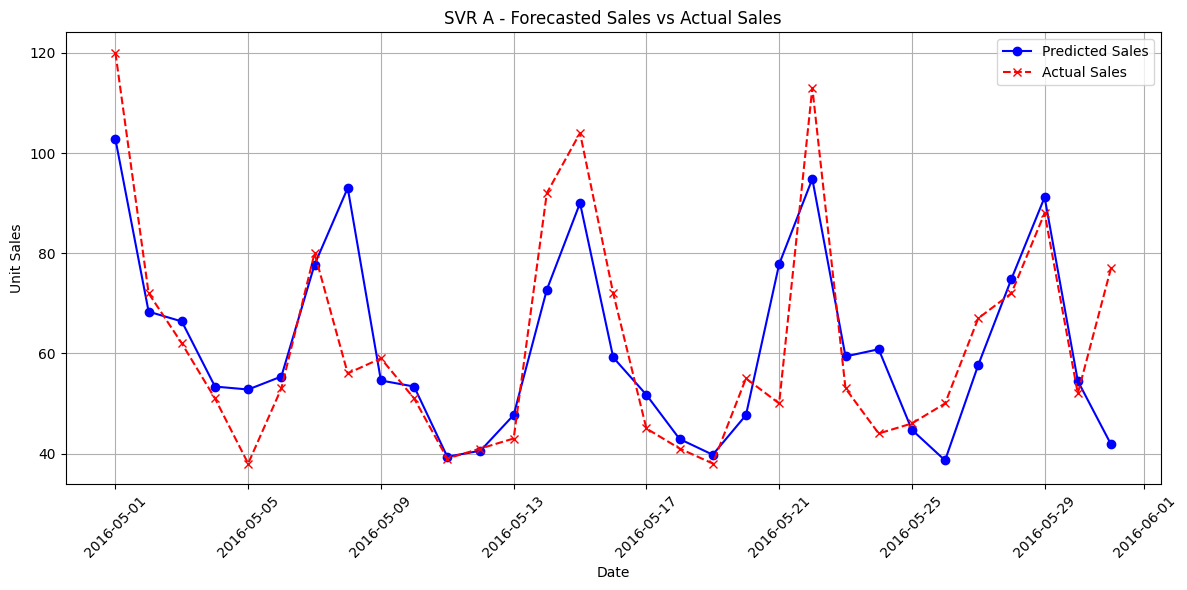

In [ ]:
# Model SVR A

model_name_A = 'SVR A'
plot_forecast_vs_actual(predictions_A, actual_data_A, model_name_A)

## Result Model SVR B

Forecast the value for the evaluation period

In [ ]:
# Model SVR B

# Define the testing period
test_start_date_B = '2016-05-01'
test_end_date_B = '2016-05-31'

# Run the forecast
predictions_B, training_dates_B = forecast_sales_B(dataset_SVR_B, test_start_date_B, test_end_date_B)
print("Forecasting completed.")

# Ensure predictions are being calculated for each expected day
expected_days_B = pd.date_range(start=test_start_date_B, end=test_end_date_B)
missing_days_B = [day.strftime('%Y-%m-%d') for day in expected_days_B if day.strftime('%Y-%m-%d') not in predictions_B]
if missing_days_B:
    print("Warning: No predictions for days:", missing_days_B)
else:
    print("All days have predictions.")

Forecasting completed.
All days have predictions.


Evaluate the results

In [ ]:
# Model SVR B

# Extract actual sales data for the test period
actual_data_B = dataset_SVR_B[test_start_date_B:test_end_date_B]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_B.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_B)} days.")

results_B = evaluate_forecast(predictions_B, actual_data_B)
print(results_B)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric      Value
0       Overall RMSE  14.971083
1             RMSE %  19.723909
2  Variance of RMSEs  88.917483
3        Overall MAE  11.628235
4              MAE %  15.319817
5       Overall MAPE  15.991467
6               Bias  -3.654720
7             Bias %  -4.814973


Predicted value for each day

In [ ]:
# Model SVR B

print("Sample predictions:")
for date in list(predictions_B.keys())[:]:
    print(f"{date}: {predictions_B[date]}")

Sample predictions:
2016-05-01: 76.01471593644428
2016-05-02: 70.61342397307843
2016-05-03: 72.61823621400974
2016-05-04: 68.94944437681906
2016-05-05: 68.69891332108675
2016-05-06: 66.21803766627445
2016-05-07: 75.364662393608
2016-05-08: 80.94620276415027
2016-05-09: 75.2608030356561
2016-05-10: 75.65341345351735
2016-05-11: 69.27448444692232
2016-05-12: 63.77313218163264
2016-05-13: 70.39277062386513
2016-05-14: 82.41590803275405
2016-05-15: 73.08062540229818
2016-05-16: 77.49833181745383
2016-05-17: 68.5385543997806
2016-05-18: 67.63969218082543
2016-05-19: 67.92030007728371
2016-05-20: 69.25760325244573
2016-05-21: 73.49082066936214
2016-05-22: 76.08575128892713
2016-05-23: 69.26521563963679
2016-05-24: 77.45672137945199
2016-05-25: 72.12589497848492
2016-05-26: 67.29406998885192
2016-05-27: 76.04404305552595
2016-05-28: 68.90343907816433
2016-05-29: 76.52876762424435
2016-05-30: 69.88389306379779
2016-05-31: 72.49580815178061


Visualization of the results

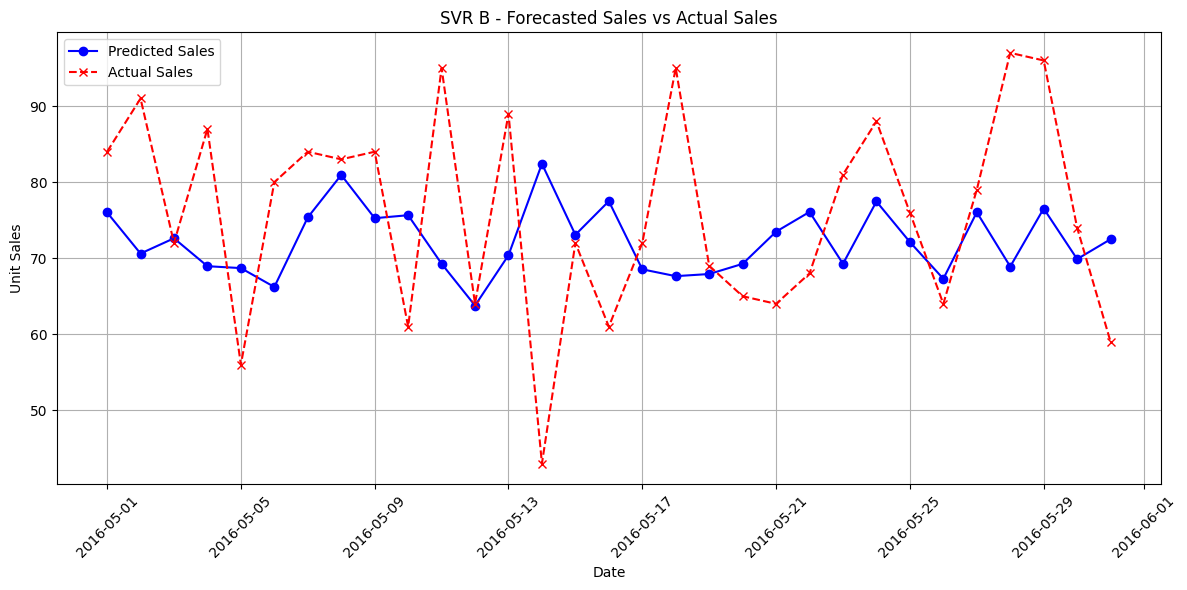

In [ ]:
# Model SVR B

model_name_B = 'SVR B'
plot_forecast_vs_actual(predictions_B, actual_data_B, model_name_B)

## Bonus Visualization

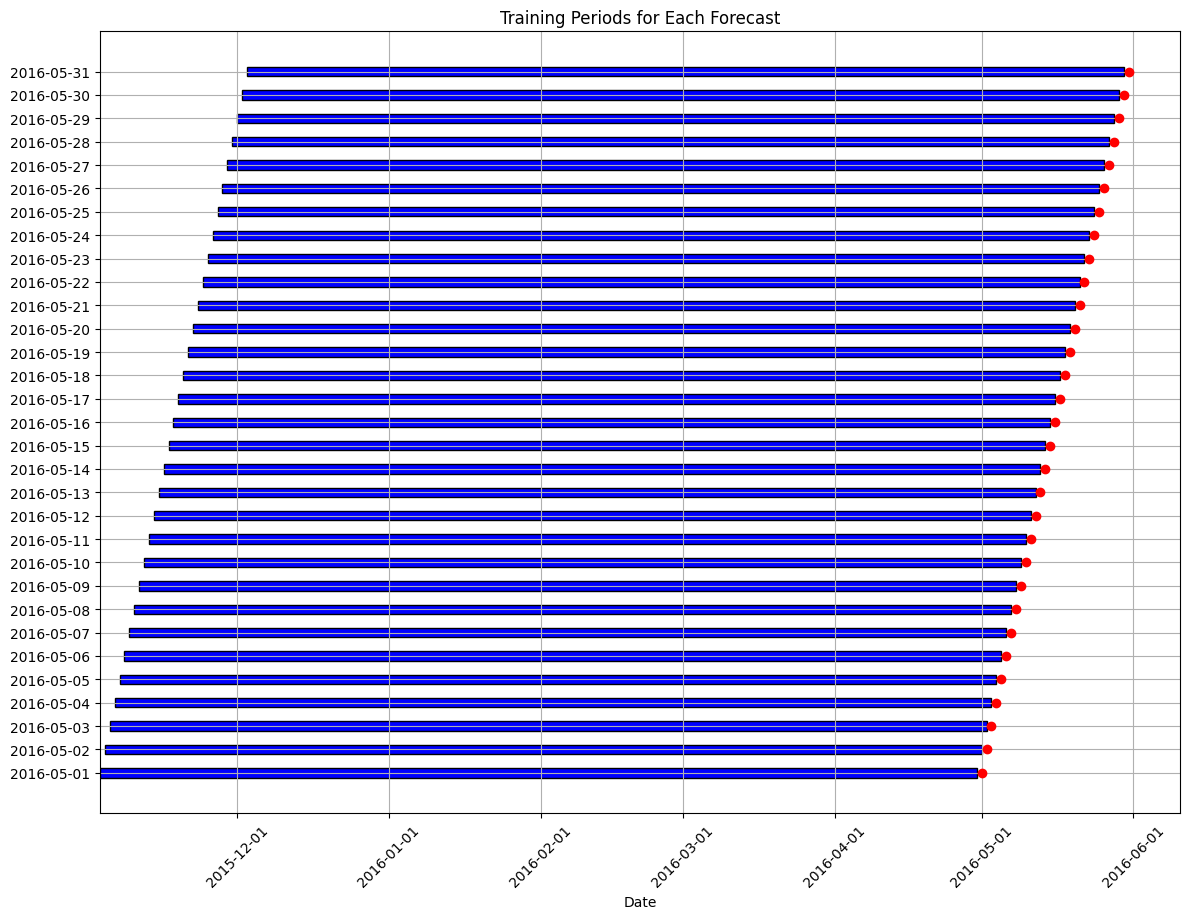

In [ ]:
def visualize_training_periods(training_dates):

    # Prepare figure and axes
    fig, ax = plt.subplots(figsize=(12, len(training_dates) * 0.3))  # Adjust size as needed

    # Generate bars for each training period
    for i, dates in enumerate(training_dates):
        start_date = dates['start']
        end_date = dates['end']
        forecast_date = end_date + pd.Timedelta(days=1)

        # Draw the training period bar
        ax.barh(i, (end_date - start_date).days, left=start_date, color='blue', edgecolor='black', height=0.4)

        # Draw a point for the forecasted day
        ax.plot(forecast_date, i, 'ro')

    # Set labels and titles
    ax.set_yticks(range(len(training_dates)))
    ax.set_yticklabels([dates['date'] for dates in training_dates])
    ax.set_xlabel('Date')
    ax.set_title('Training Periods for Each Forecast')

    # Improve date display
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function
visualize_training_periods(training_dates_A)